In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
!pip install git+https://github.com/lindermanlab/ssm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lindermanlab/ssm.git to /tmp/pip-req-build-6uhfszsb
  Running command git clone -q https://github.com/lindermanlab/ssm.git /tmp/pip-req-build-6uhfszsb
  Created wheel for ssm: filename=ssm-0.0.1-cp37-cp37m-linux_x86_64.whl size=402685 sha256=1e150cd2cfa3bde59ec7978e353b02f92e850c461db58ca41d74e1238b6d22be
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uop0_0k/wheels/c8/04/4e/bf90d9e04d0342f45dc1103b47678ce7e7ba1dbc97d431d254
Successfully built ssm


In [3]:
import ssm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [4]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [6]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [11]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', dat['brain_area'].shape, np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

print('')
print('pupil:', dat['pupil'].shape)
print('wheel:', dat['wheel'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: (698,) ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)

pupil: (3, 340, 250)
wheel: (1

In [12]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

# stim_onset = int(stim_onset/bin_size)
# response_time = response_time/bin_size

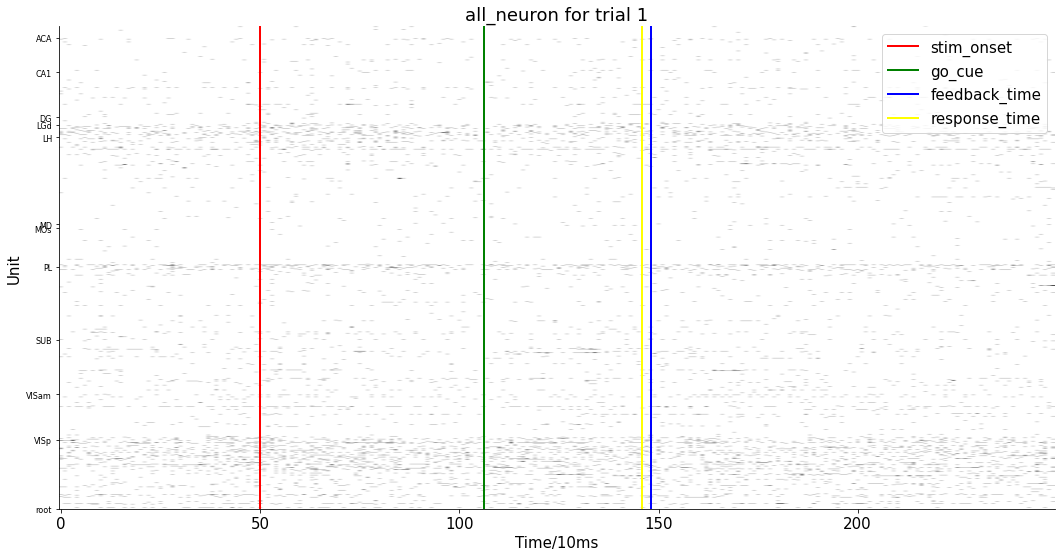

In [13]:
# Display a spike raster of the image

n_trial = 1

plt.figure(figsize=(15,8))
plt.imshow(neural_activity[:,n_trial,:], aspect='auto', cmap='gray_r')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = neural_activity.shape[2]

plt.axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
plt.axvline(x=gocue[n_trial]/bin_size, color='green', linewidth=2, label='go_cue')
plt.axvline(x=feedback_time[n_trial]/bin_size, color='blue', linewidth=2, label='feedback_time')
plt.axvline(x=response_time[n_trial]/bin_size, color='yellow', linewidth=2, label='response_time')
plt.ylabel("Unit")
plt.xlabel("Time/10ms")

unique, count=np.unique(brain_areas,return_counts=True)
yticklabels = unique
yticklabels_idx = np.cumsum(count)
plt.yticks(yticklabels_idx, yticklabels, fontsize=8)
plt.legend()
plt.tight_layout
plt.title(f'all_neuron for trial {n_trial}')
plt.show()

In [14]:
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

np.unique(barea, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([145, 155, 220,  78, 100]))

In [15]:
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0
# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0
# trials types by result
correct_id_left = np.logical_and(vis_left > 0, response > 0)
orrect_id_no = np.logical_and(vis_left == 0, response == 0)
orrect_id_right = np.logical_and(vis_left < 0, response < 0)
correct_id = np.logical_or(correct_id_left, orrect_id_no, orrect_id_right)
incorrect_id = np.logical_not(correct_id)

In [21]:
i_area=0
neural_activity_visual = neural_activity[barea==i_area][:, :, :]
neural_activity_visual.shape

(145, 340, 250)

In [22]:
num_neurons = neural_activity_visual.shape[0]
num_trials = neural_activity_visual.shape[1]
time_bins=250
neural_activity_visual1 = neural_activity_visual.reshape(num_neurons, num_trials*time_bins)
neural_activity_visual1.shape

(145, 85000)

  0%|          | 0/100 [00:00<?, ?it/s]

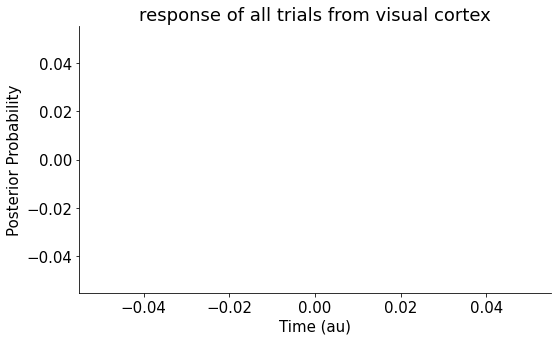

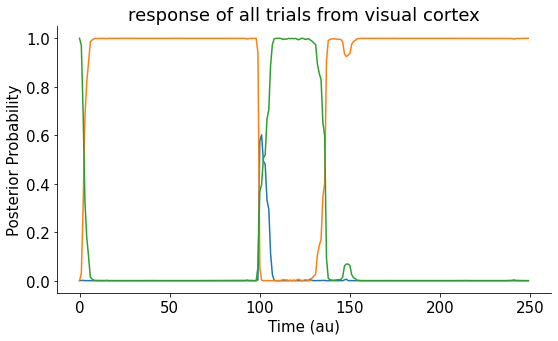

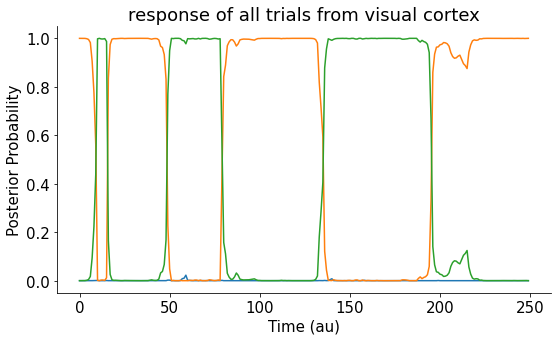

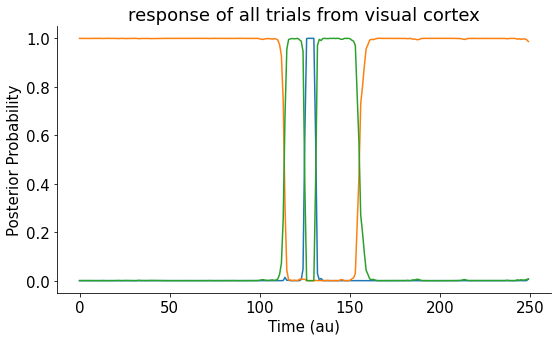

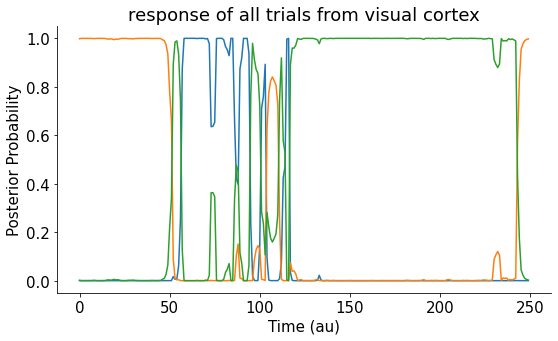

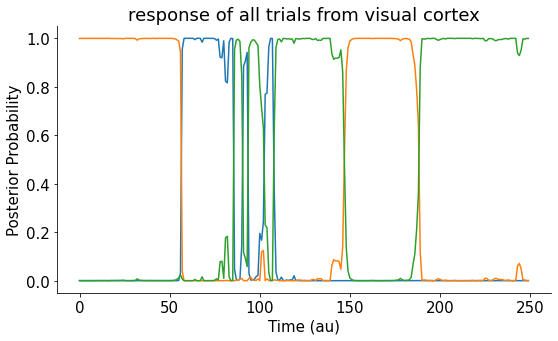

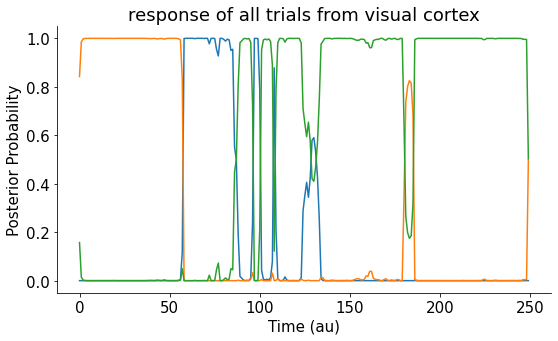

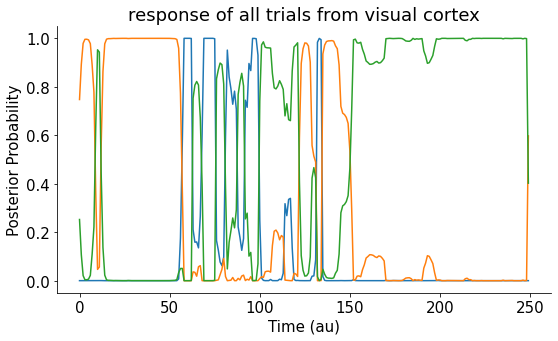

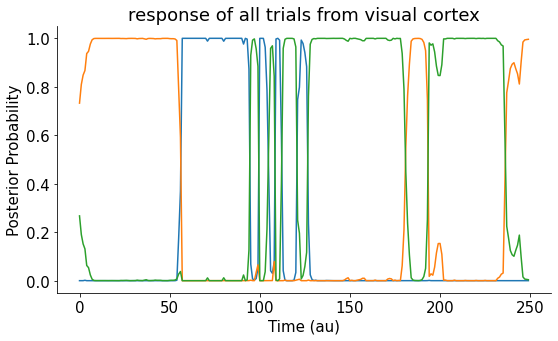

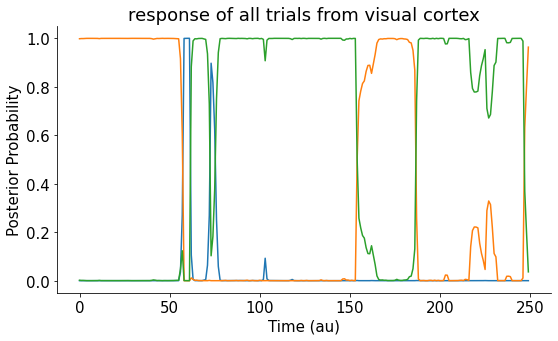

In [25]:
#Let's fit a HMM one more time, but instead of using the verberti method to obtain the most-likely latent state sequence,
#we will get the Maximum a posteriori estimation of the latent state sequence. this way, we can impose a probability threshold 
#and look at only time points where the model is sure it found the right state; this is usually what you want to do because you don't really know if the model is doing a good job capturing the complexity of the data
num_states = 3
N_iters=100
obs_dim=145
#Let's do a full model fit and get the state-sequence
hmm = ssm.HMM(num_states, obs_dim, observations="poisson")
hmm_lls = hmm.fit(neural_activity_visual1.T, method="em", num_iters=N_iters)

#For visualization purposes
most_likely_states = hmm.most_likely_states(neural_activity_visual1.T)
#hmm.permute(find_permutation(true_states, most_likely_states))
#most_likely_states = hmm.most_likely_states(synthetic_data)

#Look at this one line magic! One line
posterior_probabilities, expected_joints, log_likes = hmm.expected_states(neural_activity_visual1.T)

#posterior_probabilities is of shape (time_bins x num_states); each time step has 5 probabilities associated with it for each state
#The MAP estimate is the state sequence with the largest posterior probability
MAP_sequence = np.argmax(posterior_probabilities,axis=1)
MAP_mask = np.max(posterior_probabilities,axis=1) > 0.8

for i in range(10):
 fig, ax = plt.subplots(figsize=(8,5))
 ax.plot(posterior_probabilities[(i)*250:250*(i+1)])
 ax.set_ylabel('Posterior Probability')
 ax.set_xlabel('Time (au)')
 plt.title('response of all trials from visual cortex')

In [27]:
import scipy.io as sio
from google.colab import files

In [30]:
sio.savemat('ppm.mat',{'posterior_probabilities':posterior_probabilities})
files.download("ppm.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
posterior_probabilities.shape

(85000, 3)

In [33]:
most_likely_states.shape

(85000,)

In [35]:
pupil=dat['pupil']
pupil.shape

(3, 340, 250)

In [36]:
pupil_area=pupil[1,:,:]
pupil_area.shape

(340, 250)

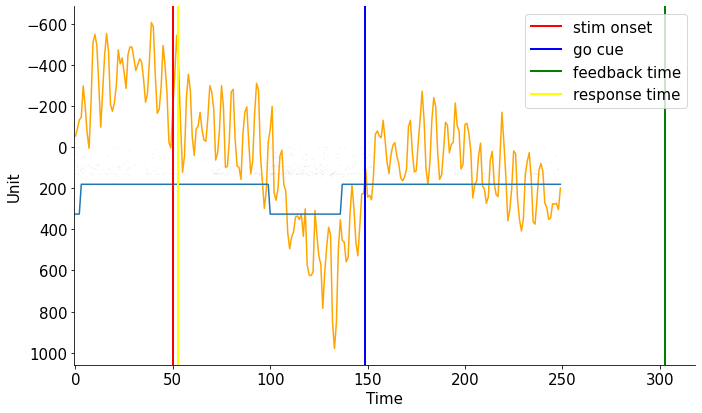

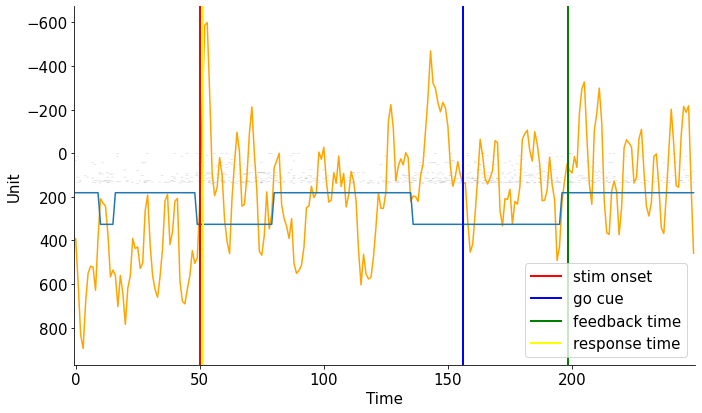

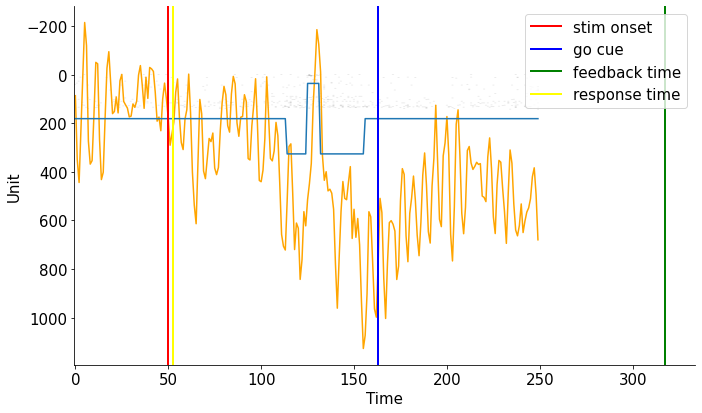

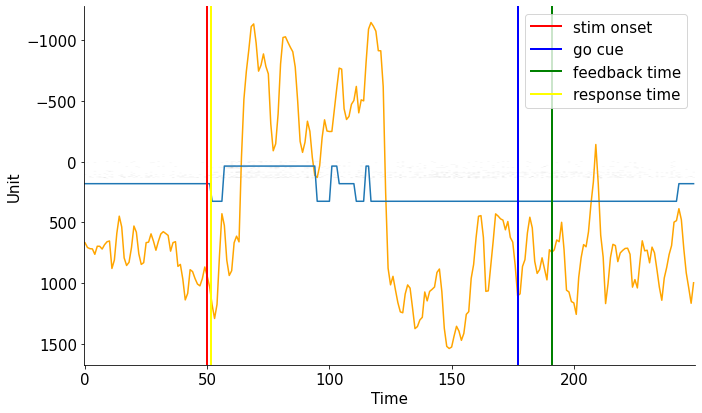

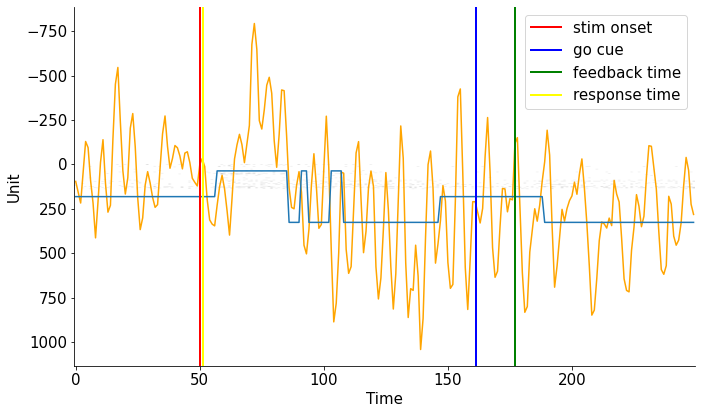

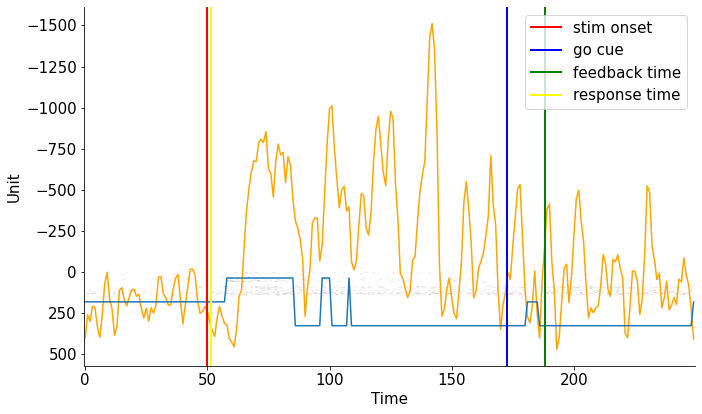

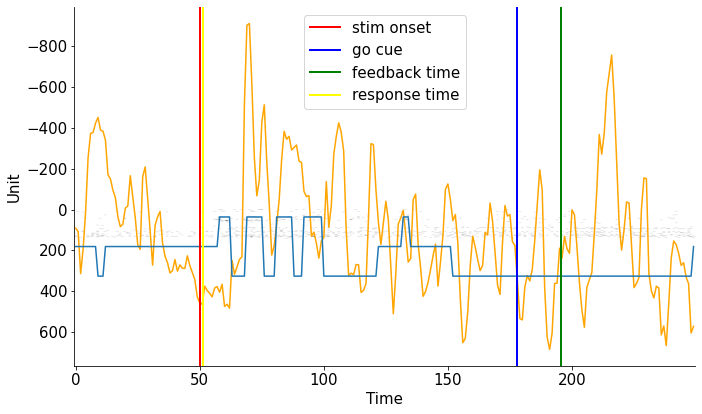

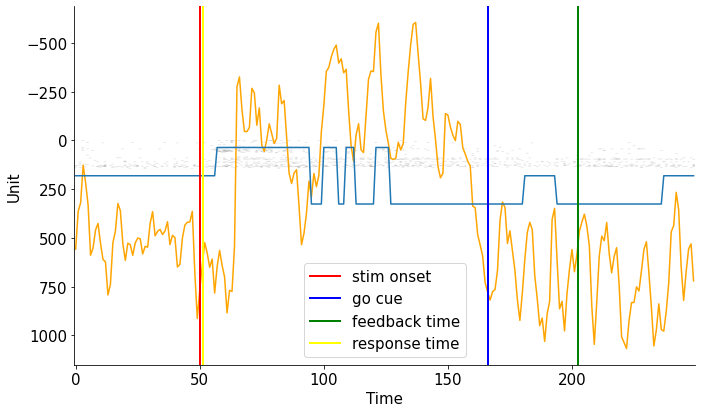

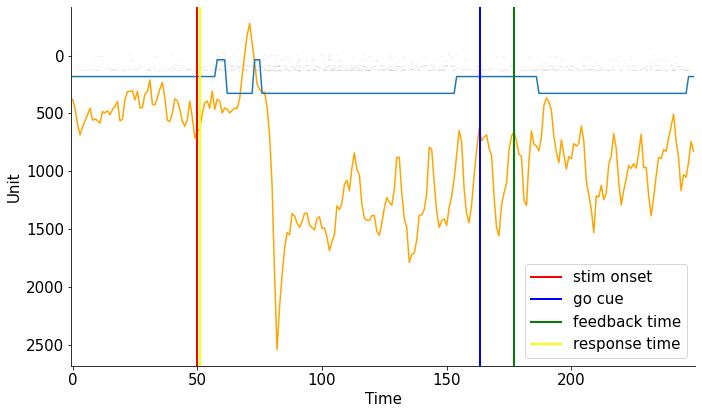

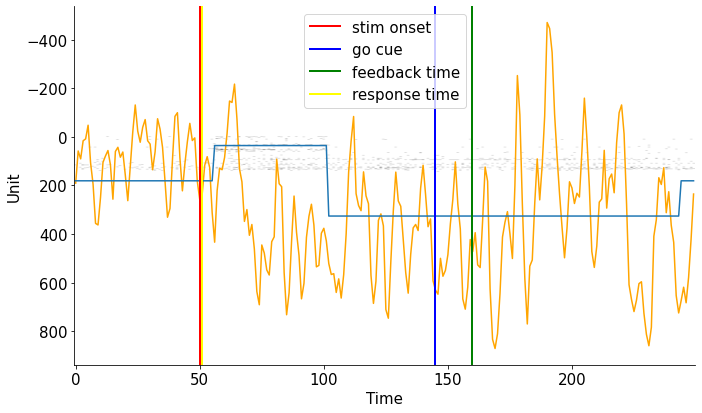

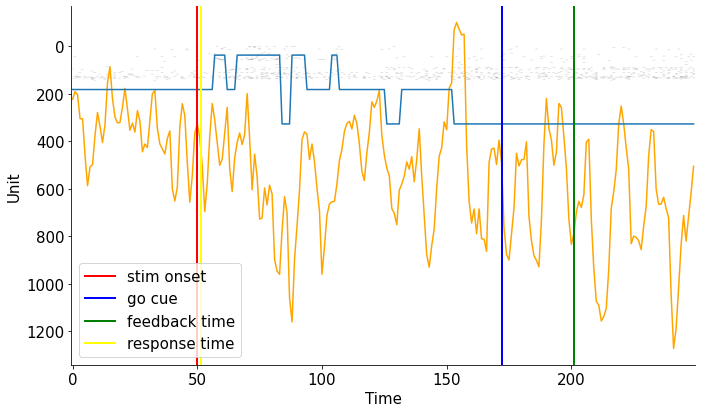

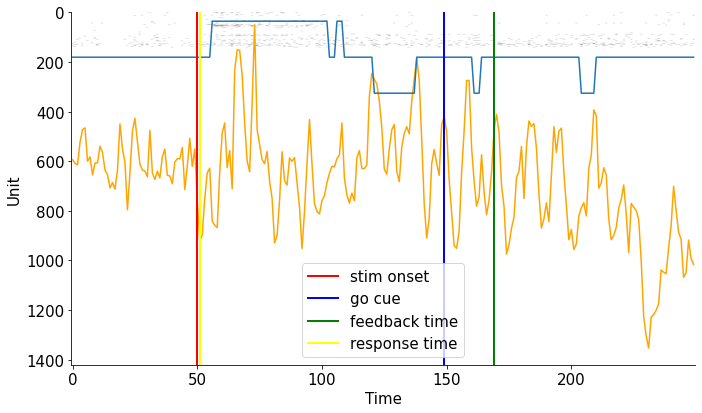

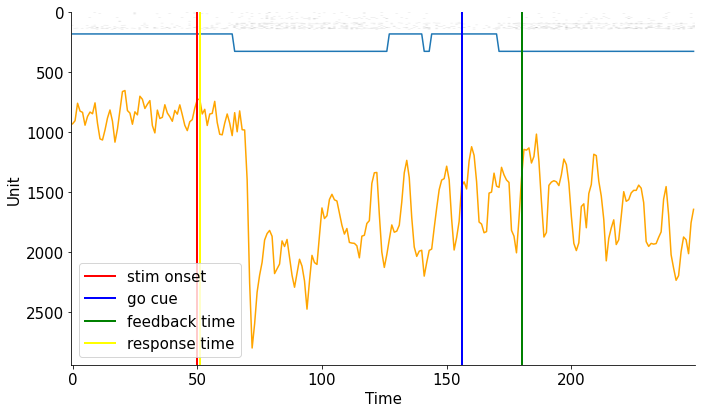

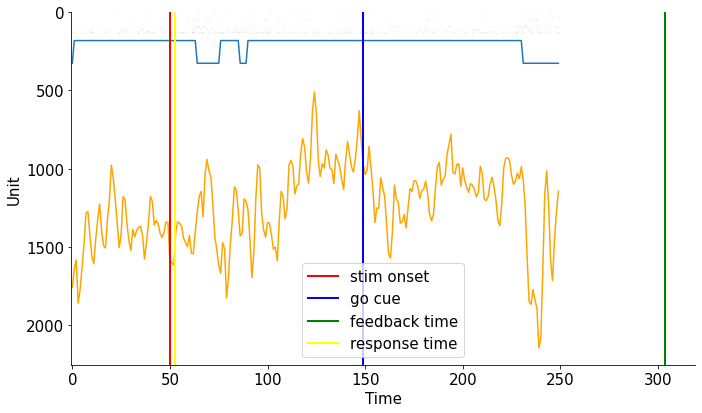

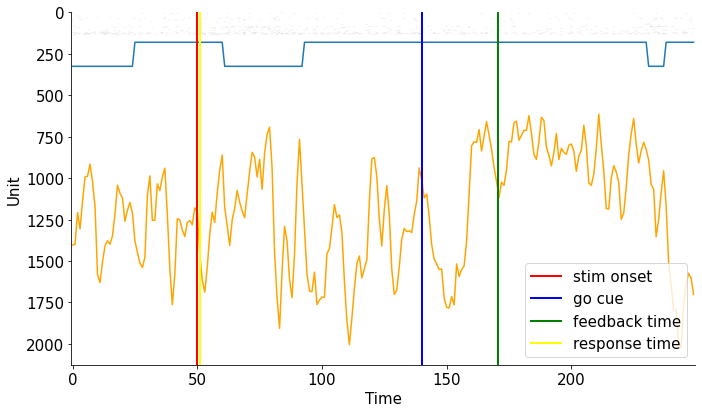

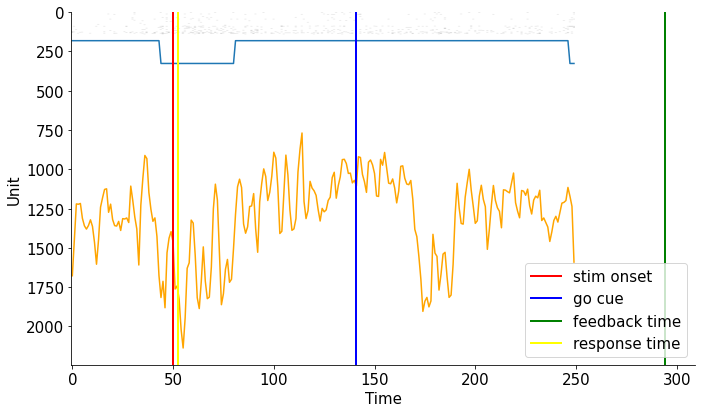

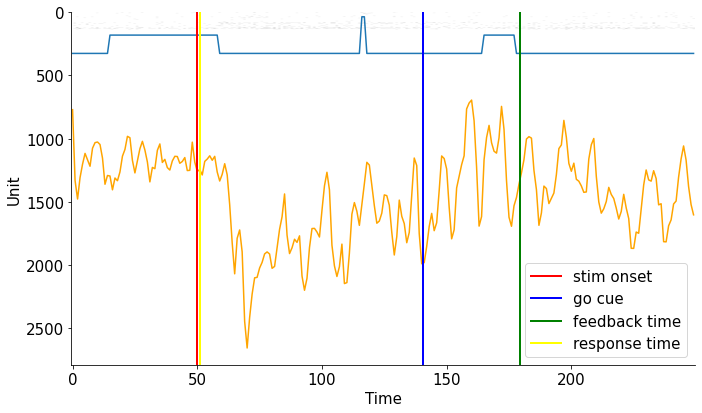

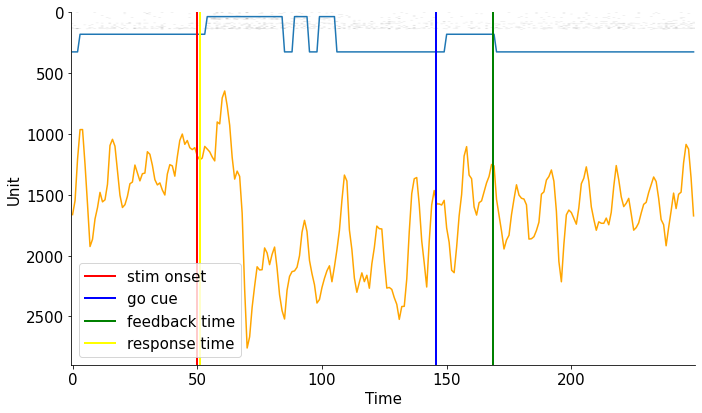

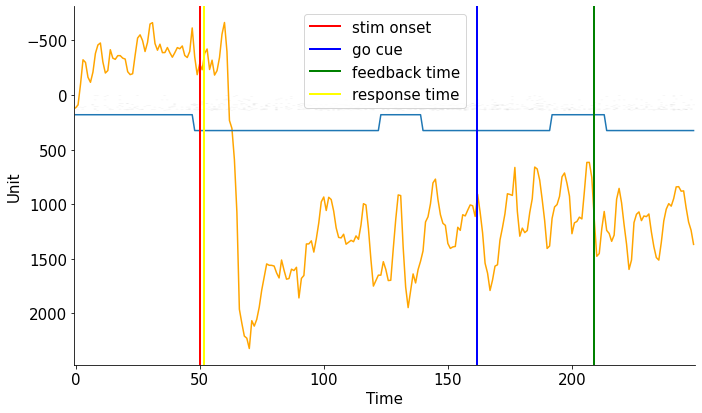

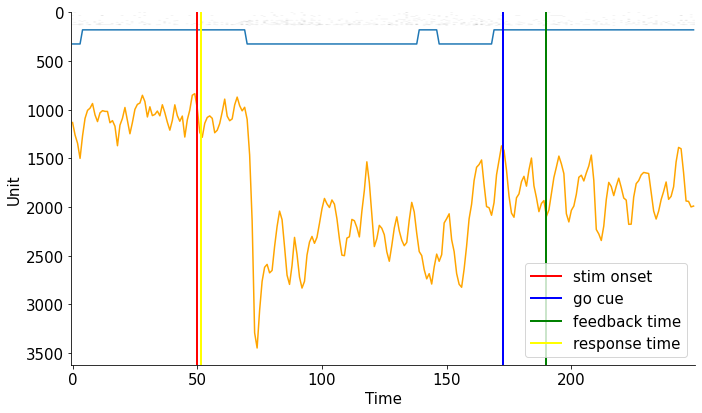

In [47]:
for n in range(20):
 plt.figure(figsize=(10,6))
 plt.imshow( (neural_activity_visual1[:,n*250:(n+1)*250]), aspect='auto',cmap='gray_r')
 plt.plot(pupil_area[n,:]*1450,color='orange')
 plt.plot((most_likely_states[n*250:(n+1)*250]+1/(num_states+1))*145)
 #plt.plot((posterior_probabilities[n*250:(n+1)*250]*145)
 ax.plot(posterior_probabilities[(n)*250:250*(n+1)])
 #plt.axis('off')

 # Label the different phases of the trial movement activity
 time_bins = neural_activity.shape[2]
 plan_start = stim_onset/bin_size
 move_start = gocue[n]/bin_size+plan_start
 feedback_time1=feedback_time[n]/bin_size+plan_start
 response_time1=response_time[n]+plan_start
 plt.axvline(x=plan_start, color='red', linewidth=2, label='stim onset')
 plt.axvline(x=move_start, color='blue', linewidth=2, label='go cue')
 plt.axvline(x=feedback_time1, color='green', linewidth=2, label='feedback time')
 plt.axvline(x=response_time1, color='yellow', linewidth=2, label='response time')
 #ax.plot(posterior_probabilities[(n)*250:250*(n+1)])
 plt.ylabel("Unit")
 plt.xlabel("Time")
 plt.legend()
 #plt.plot((posterior_probabilities[n*250:(n+1)*250]*145)
 plt.tight_layout
 plt.show()

In [48]:
def get_state_durations(MAP_sequence, mask, K):
    ##===== calculate state durations =====##  
    # K+1 too, b/c measuring NaN state durations too.
    state_duration_list = [[] for s in range(K+1)]
    state_usage_raw =  np.zeros(K+1)
    
    MAPcp = MAP_sequence.copy()
    MAPcp[~mask] = -1

    #Loop over states and nan-states
    for state in range(-1,K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts
        state_duration_list[state] = state_durations

        state_usage_raw[state] += np.sum(state_durations)
    
    #Normalize State Usage
    state_usage = state_usage_raw/np.sum(state_usage_raw) 
    
    return (state_duration_list, state_usage)


In [49]:
from ssm.plots import gradient_cmap, white_to_color_cmap

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

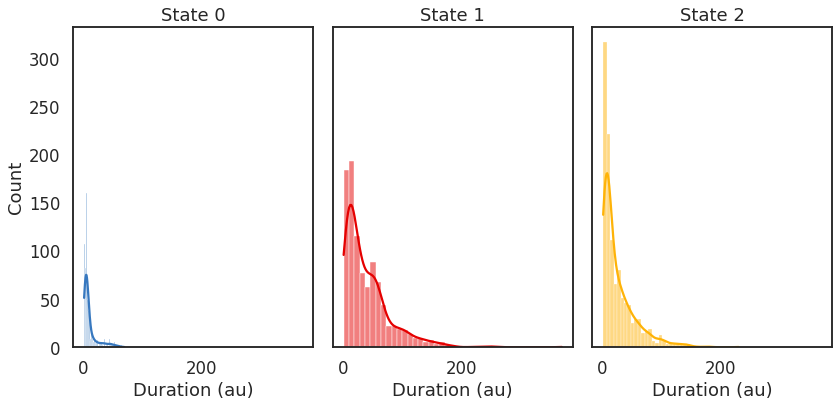

In [50]:
#state_duration_list_true, state_usage_true = get_state_durations(most_likely_states,np.ones(most_likely_states.shape,dtype=bool),num_states)
state_duration_list, state_usage = get_state_durations(MAP_sequence,MAP_mask,num_states)


fig, axes = plt.subplots(1,num_states,figsize=(12, 6),sharey=True,sharex=True)

for state in range(num_states):
    ax = axes[state]
    sns.histplot(state_duration_list[state],color=colors[state],ax=ax,kde=True)
    ax.set_title('State {}'.format(state))
    
    ax = axes[state]
    ax.set_xlabel('Duration (au)')

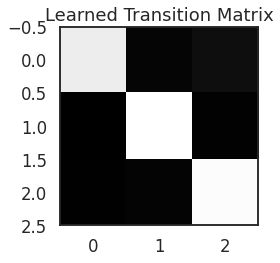

In [51]:
learned_transition_mat = hmm.transitions.transition_matrix


im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()